# Install necessary libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import ParameterGrid, train_test_split



# Loading and preprocessing the dataset

In [2]:
!git clone "https://github.com/cincin-2399/Stock-Price-Prediction-Using-ML-and-DL-techniques.git"

Cloning into 'Stock-Price-Prediction-Using-ML-and-DL-techniques'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 193 (delta 38), reused 57 (delta 21), pack-reused 86
Receiving objects: 100% (193/193), 6.14 MiB | 12.30 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [3]:
path='/kaggle/working/Stock-Price-Prediction-Using-ML-and-DL-techniques/Data/processed/GAS_dropna.csv'
df = pd.read_csv(path)

df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")
df = df.sort_values('Date') 
df = df.reset_index(drop=True)
df = df.set_index('Date') 
df.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-21,30833.333984,34250.000000,30833.333984,34166.667969,32736.435547,3002495.0
2012-05-22,35833.332031,35833.332031,35416.667969,35833.332031,34333.332031,5801459.0
2012-05-23,35750.000000,35833.332031,34083.332031,34083.332031,32656.587891,1266935.0
2012-05-24,32500.000000,33333.332031,32416.666016,32416.666016,31059.689453,1211255.0
2012-05-25,32416.666016,33166.667969,30916.666016,32500.000000,31139.535156,1112711.0
2012-05-28,32666.666016,32666.666016,31250.000000,31333.333984,30021.707031,548879.0
2012-05-29,30250.000000,30833.333984,30083.333984,30583.333984,29303.101563,501959.0
2012-05-30,30833.333984,31583.333984,30583.333984,31500.000000,30181.394531,204335.0
2012-05-31,31000.000000,31500.000000,30583.333984,31000.000000,29702.326172,322835.0


# Spliting the dataset into X and y

In [4]:
def convert_dataset(dataset, time_step=1, target_col='Close', split=False, test_size=0.2):
    """   
    Args:
        dataset (pandas.DataFrame): The input dataset.
        time_step (int): The number of time steps to use for each sample.
        target_col (str): The name of the target column.
        split(boolean): Whether you want to split the dataset into train, test or validation or not
        test_size(float): The test size you wish to split. It is 0.2 by default.
        
    Returns:
        tuple: A tuple containing the X and Y of the dataset (X,y)
    """
    target_idx = dataset.columns.get_loc(target_col)
    
    feature_indices = list(range(len(dataset.columns)))
    feature_indices.remove(target_idx)
    
    X, y = [], []
    
    for i in range(len(dataset) - time_step):
        features = dataset.iloc[i:(i + time_step), feature_indices].values
        X.append(features)
        
        target = dataset.iloc[i + time_step, target_idx]
        y.append(target)
    
    X = np.array(X)
    y = np.array(y)
    
    if split:
        split_idx = int(len(X) * (1 - test_size))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        return X_train, X_test, y_train, y_test
    else:
        return X, y
        
time_step=30 
X,y = convert_dataset(df,time_step=time_step)
print(X)
print(y)

[[[  30833.333984   34250.         30833.333984   32736.435547
   3002495.      ]
  [  35833.332031   35833.332031   35416.667969   34333.332031
   5801459.      ]
  [  35750.         35833.332031   34083.332031   32656.587891
   1266935.      ]
  ...
  [  31500.         32000.         31500.         30341.083984
     67787.      ]
  [  32083.333984   32083.333984   31666.666016   30740.310547
    377687.      ]
  [  32250.         32250.         32000.         30660.464844
    709355.      ]]

 [[  35833.332031   35833.332031   35416.667969   34333.332031
   5801459.      ]
  [  35750.         35833.332031   34083.332031   32656.587891
   1266935.      ]
  [  32500.         33333.332031   32416.666016   31059.689453
   1211255.      ]
  ...
  [  32083.333984   32083.333984   31666.666016   30740.310547
    377687.      ]
  [  32250.         32250.         32000.         30660.464844
    709355.      ]
  [  32250.         33333.332031   32000.         30740.310547
    506279.      ]]



# Setting up the model

In [8]:
def performXGBoost(X_train, y_train, X_test, y_test, parameters, return_model=False):
    
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
    
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    # Fit the scalers on the training data and transform
    X_train_scaled = X_scaler.fit_transform(X_train_reshaped)
    y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
    
    # Transform the test data using the fitted scalers
    X_test_scaled = X_scaler.transform(X_test_reshaped) 
    
    print(f"Training XGBoost model with parameters: {parameters}")
    
    XGBoost_model = XGBRegressor(n_estimators=parameters['n_estimators'], 
                                 max_depth=parameters['max_depth'], 
                                 learning_rate=parameters['learning_rate'],
                                 objective='reg:squarederror', 
                                 random_state=42) 
    
    XGBoost_model.fit(X_train_scaled, y_train_scaled, verbose=False)
    
    y_pred_train = XGBoost_model.predict(X_train_scaled)
    y_pred_test = XGBoost_model.predict(X_test_scaled)
    
    # Inverse transform the predictions back to original scale
    y_pred_train = y_scaler.inverse_transform(y_pred_train.reshape(-1, 1)) 
    y_pred_test = y_scaler.inverse_transform(y_pred_test.reshape(-1, 1))
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print(f"Training RMSE: {rmse_train:.4f}")
    print(f"Testing RMSE: {rmse_test:.4f}")
    print(f"Training MAPE: {mape_train:.4f}")
    print(f"Testing MAPE: {mape_test:.4f}")
    print(f"Training R2 score: {r2_train:.4f}") 
    print(f"Testing R2 score: {r2_test:.4f}")
    print("---")
    
    if return_model:
        return XGBoost_model,X_scaler, y_scaler,[rmse_train, rmse_test, mape_train, mape_test, r2_train, r2_test]
    else:
        return [rmse_train, rmse_test, mape_train, mape_test, r2_train, r2_test]


## Since the dataset is time series type, so in order to find out the best parameters for the model, we choose Cross Validation for Time series as our approach.

In [6]:
def CV_timeseries_hypertuning(X, y, number_folds):
    param_grid = {
        'n_estimators': [100, 500, 1000],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.05, 0.1]
    }
    param_list = list(ParameterGrid(param_grid))
    
    results_valid = []
    results_test = []
    
    k = int(np.floor(X.shape[0] / number_folds))
    
    for i in range(3, number_folds + 1):
        print(f"Fold {i}/{number_folds}")
        
        split = (i - 1) / i
        index = int(np.floor(X.shape[0] * split))
        
        X_train_validFolds = X[:index]
        y_train_validFolds = y[:index]
        
        index_valid = int((i - 2) * index / (i - 1))
        
        X_trainFolds = X_train_validFolds[:index_valid]
        y_trainFolds = y_train_validFolds[:index_valid]
        X_validFolds = X_train_validFolds[index_valid:]
        y_validFolds = y_train_validFolds[index_valid:]
        
        X_testFolds = X[index:]
        y_testFolds = y[index:]
        
        for params in param_list:
            metrics_valid = performXGBoost(X_trainFolds, y_trainFolds, X_validFolds, y_validFolds, params)
            results_valid.append({
                'parameters': params,
                'rmse_train': metrics_valid[0],
                'rmse_valid': metrics_valid[1],
                'mape_train': metrics_valid[2],
                'mape_valid': metrics_valid[3],
                'r2_train': metrics_valid[4],
                'r2_valid': metrics_valid[5]
            })
        
        sorted_results_valid = sorted(results_valid, key=lambda x: x['rmse_valid'])
        best_parameters = sorted_results_valid[0]['parameters']
        
        print(f"Best parameters for fold {i}: {best_parameters}")
        
        metrics_test = performXGBoost(X_train_validFolds, y_train_validFolds, X_testFolds, y_testFolds, best_parameters)
        results_test.append({
            'parameters': best_parameters,
            'rmse_train': metrics_test[0],
            'rmse_test': metrics_test[1],
            'mape_train': metrics_test[2],
            'mape_test': metrics_test[3],
            'r2_train': metrics_test[4],
            'r2_test': metrics_test[5]
        })
    
    avg_results = {
        'rmse_train': np.mean([result['rmse_train'] for result in results_test]),
        'rmse_test': np.mean([result['rmse_test'] for result in results_test]),
        'mape_train': np.mean([result['mape_train'] for result in results_test]),
        'mape_test': np.mean([result['mape_test'] for result in results_test]),
        'r2_train': np.mean([result['r2_train'] for result in results_test]),
        'r2_test': np.mean([result['r2_test'] for result in results_test])
    }
    
    print("Average results:")
    print(f"Training RMSE: {avg_results['rmse_train']:.4f}")
    print(f"Testing RMSE: {avg_results['rmse_test']:.4f}")
    print(f"Training MAPE: {avg_results['mape_train']:.4f}")
    print(f"Testing MAPE: {avg_results['mape_test']:.4f}")
    print(f"Training R2 score: {avg_results['r2_train']:.4f}")
    print(f"Testing R2 score: {avg_results['r2_test']:.4f}")
    
    best_params_overall = sorted_results_valid[0]['parameters']
    print(f"Overall best parameters: {best_params_overall}")
    
    return avg_results, best_params_overall


In [7]:
avg_results, best_params_overall=CV_timeseries_hypertuning(X,y,5)

Fold 3/5
Training XGBoost model with parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Training RMSE: 7301.4885
Testing RMSE: 9682.7409
Training MAPE: 0.1169
Testing MAPE: 0.0939
Training R2 score: 0.8545
Testing R2 score: 0.6918
---
Training XGBoost model with parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Training RMSE: 906.0503
Testing RMSE: 2295.9881
Training MAPE: 0.0128
Testing MAPE: 0.0198
Training R2 score: 0.9978
Testing R2 score: 0.9827
---
Training XGBoost model with parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}
Training RMSE: 740.0676
Testing RMSE: 2288.2723
Training MAPE: 0.0104
Testing MAPE: 0.0199
Training R2 score: 0.9985
Testing R2 score: 0.9828
---
Training XGBoost model with parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
Training RMSE: 7235.2046
Testing RMSE: 9669.6561
Training MAPE: 0.1147
Testing MAPE: 0.0924
Training R2 score: 0.8571
Testing R2 score: 0.6926
---


# Training the model and use it for prediction

In [9]:
X_train,X_test,y_train,y_test=convert_dataset(df,time_step=30,split=True,test_size=0.3)
val_size = len(X_test) // 2  

X_val = X_test[:val_size]
y_val = y_test[:val_size]

X_test = X_test[val_size:]
y_test = y_test[val_size:]

XGBoost_model, X_scaler, y_scaler, score = performXGBoost(X_train, y_train, X_val, y_val, best_params_overall, return_model=True)

Training XGBoost model with parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Training RMSE: 1281.8566
Testing RMSE: 2263.2769
Training MAPE: 0.0147
Testing MAPE: 0.0193
Training R2 score: 0.9958
Testing R2 score: 0.9600
---


In [10]:
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
X_test_scaled = X_scaler.transform(X_test_reshaped)
y_pred_test = XGBoost_model.predict(X_test_scaled)
y_pred_test = y_scaler.inverse_transform(y_pred_test.reshape(-1, 1))


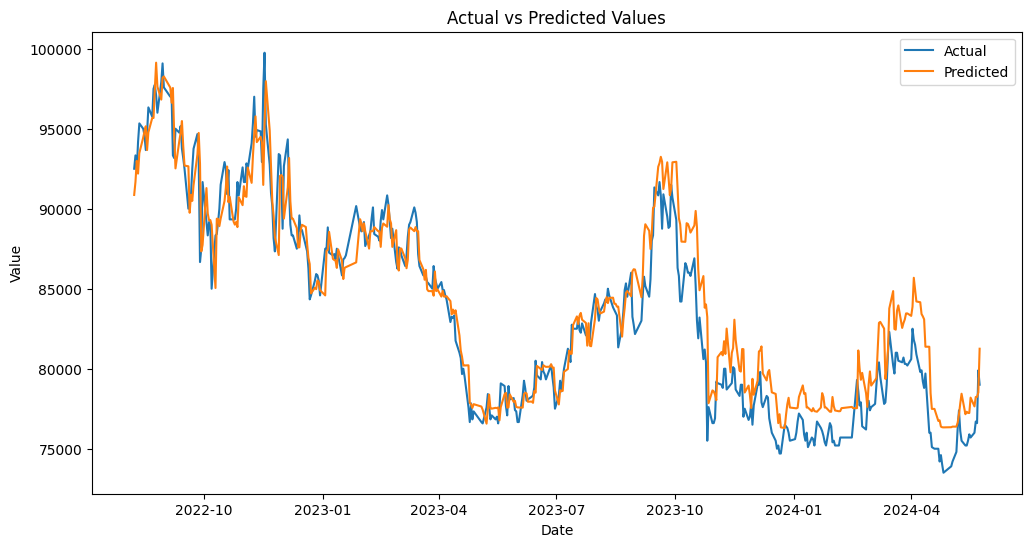

In [13]:
pred_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred_test.flatten()}, index=test_dates)

# Plot the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(pred_df.index, pred_df['Actual'], label='Actual')
plt.plot(pred_df.index, pred_df['Predicted'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [15]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_percentage_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2 score:", r2)

RMSE: 1964.9576649746489
MAE: 0.01835699524371477
R2 score: 0.9024808753404255
